In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [3]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DXG Historical Data 1_6.csv')

In [4]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 5s 132ms/step - loss: 0.0294 - val_loss: 0.0114
Epoch 2/100
16/16 [==============================] - 1s 94ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 3/100
16/16 [==============================] - 1s 94ms/step - loss: 0.0018 - val_loss: 7.9456e-04
Epoch 4/100
16/16 [==============================] - 1s 83ms/step - loss: 6.9293e-04 - val_loss: 4.9284e-04
Epoch 5/100
16/16 [==============================] - 2s 95ms/step - loss: 6.2737e-04 - val_loss: 4.6076e-04
Epoch 6/100
16/16 [==============================] - 2s 130ms/step - loss: 5.9978e-04 - val_loss: 4.2055e-04
Epoch 7/100
16/16 [==============================] - 2s 96ms/step - loss: 5.7102e-04 - val_loss: 4.3679e-04
Epoch 8/100
16/16 [==============================] - 2s 106ms/step - loss: 5.3967e-04 - val_loss: 4.1039e-04
Epoch 9/100
16/16 [==============================] - 1s 62ms/step - loss: 5.2026e-04 - val_loss: 3.8566e-04
Epoch 10/100
16/16 [=========================

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

15/15 [==============================] - 0s 14ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16887.338855844253


In [15]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99838843969124
Testing MAE: 16382.190671867156


In [16]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.24527983367443085], [0.24034838378429413], [0.23523153364658356], [0.23003092408180237], [0.2247902750968933], [0.2195286899805069], [0.21425855159759521], [0.2089897245168686], [0.20373038947582245], [0.1984875649213791], [0.19326713681221008], [0.18807390332221985], [0.1829119175672531], [0.1777845323085785], [0.1726943701505661], [0.16764351725578308], [0.1626337319612503], [0.15766629576683044], [0.15274211764335632], [0.14786182343959808], [0.14302577078342438], [0.13823416829109192], [0.1334870308637619], [0.1287841796875], [0.12412534654140472], [0.11951015144586563], [0.11493811756372452], [0.110408715903759], [0.10592138767242432], [0.10147552937269211], [0.09707048535346985], [0.09270556271076202], [0.08838013559579849], [0.08409350365400314], [0.07984498143196106], [0.07563386857509613], [0.07145952433347702], [0.06732127070426941], [0.06321845948696136], [0.05915046110749245], [0.05511666089296341], [0.051116421818733215], [0.04714919999241829], [0.04321438819169998], [

In [17]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16552.96689716],
       [16355.65514876],
       [16150.92536958],
       [15942.84430034],
       [15733.16121787],
       [15522.64046194],
       [15311.77748212],
       [15100.96696867],
       [14890.53624028],
       [14680.76611131],
       [14471.89208428],
       [14264.10613844],
       [14057.57044259],
       [13852.41914375],
       [13648.75717466],
       [13446.66800457],
       [13246.22198613],
       [13047.4703933 ],
       [12850.44959482],
       [12655.18463146],
       [12461.68981224],
       [12269.97348408],
       [12080.03624319],
       [11891.87093506],
       [11705.46682793],
       [11520.80871849],
       [11337.87752803],
       [11156.65209115],
       [10977.11005002],
       [10799.22725818],
       [10622.97748243],
       [10448.33299906],
       [10275.26876731],
       [10103.75676535],
       [ 9933.76956758],
       [ 9765.27915217],
       [ 9598.25988215],
       [ 9432.68463002],
       [ 9268.52746069],
       [ 9105.76318433],


In [18]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [19]:
print(y_pred_with_test_data.shape)
test_data.shape

(580,)


(480, 1)

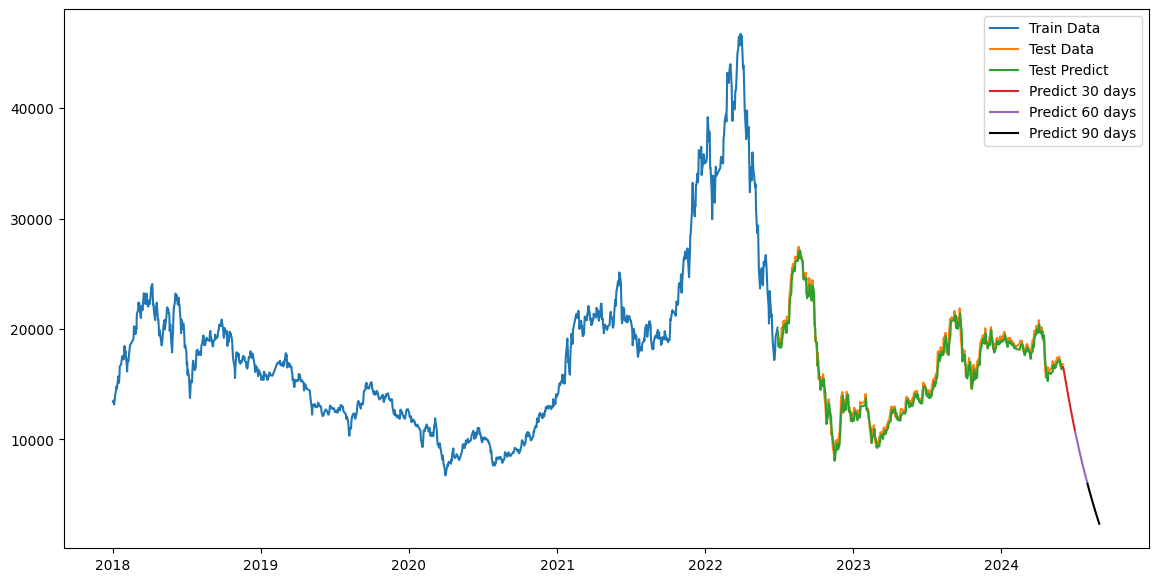

In [21]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()